# Using the Pyspindl library for Spectral Indices with Xarray and Holoviews

                       Jyri P. Hämäläinen, University of Jyväskylä, jyri.p.hamalainen@gmail.com

In this notebook I present an example on how to easily analyze hyperspectral data using Pyspindl, Jyputer Notebooks, Xarray and Holoviews. All packages imported below are installed in a conda-forge environment, with the so far unpublished index library installed into the environment from git.

In [1]:
import xarray as xr
import numpy as np
import holoviews as hv; hv.extension('matplotlib') #Bokeh is a popular alternative, but may have issues with memory
import pyspindl as ps
# import indices as ind
import pandas as pd
from scipy import stats
import warnings; warnings.simplefilter('ignore') #Ignoring warnings to make the finished notebook easier to read

## Processing hyperspectral images with Xarray

In this example, I use data collected from a field in the municipality of Vihti in 2012.

In [2]:
field = xr.open_rasterio('/n/archive/IT/hsi-data/vihti2012/Vihti2012.dat')

It is useful to check the data in case it needs processing, which is the case here. The data has been converted from radiance to reflectance with the help of known targets, but has unphysical negative values as a side effect, as can be easily seen when the image bands are viewed with holoviews.

:AdjointLayout
   :HoloMap   [band]
      :Image   [x,y]   (Reflectance)
   :HoloMap   [band]
      :Histogram   [Reflectance]   (Reflectance_frequency)
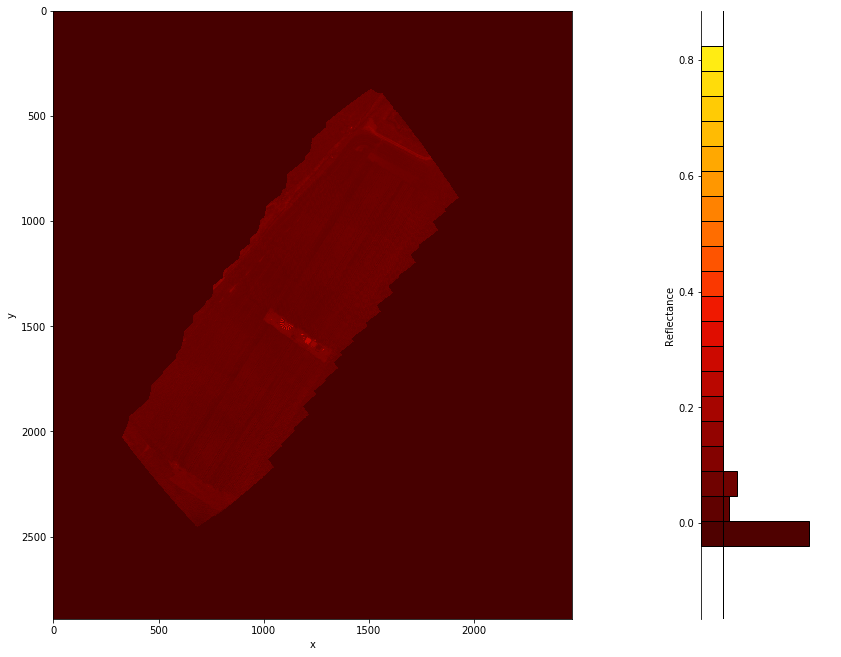
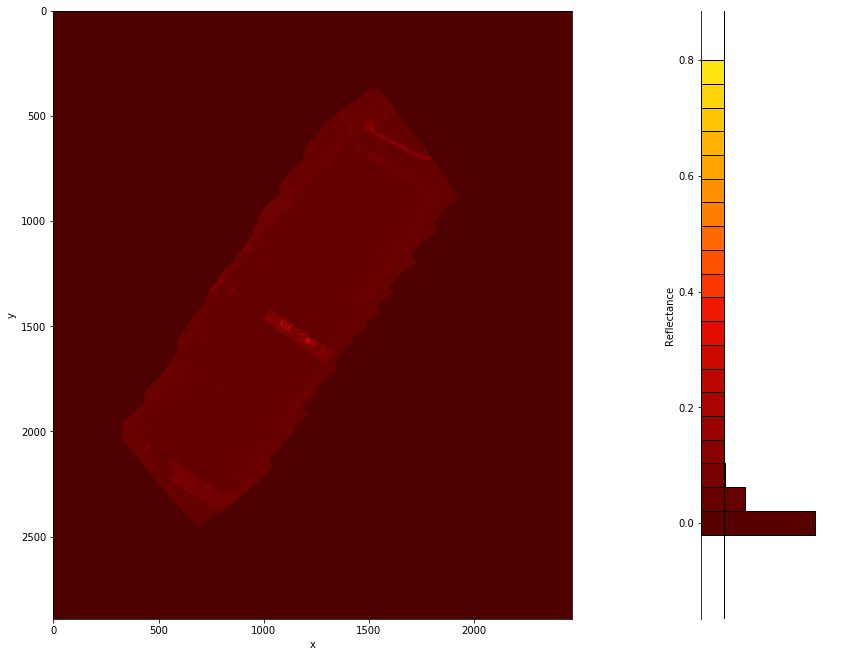
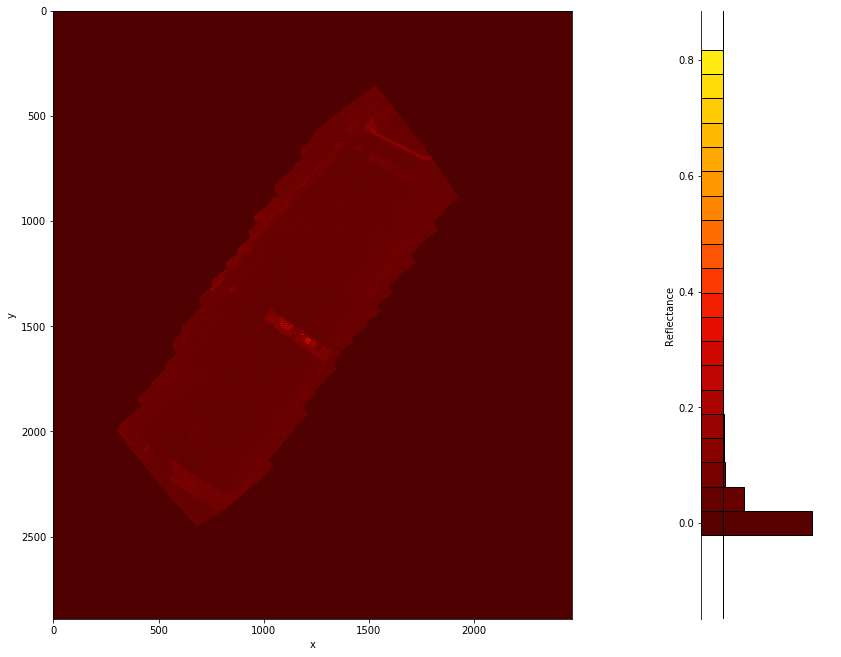
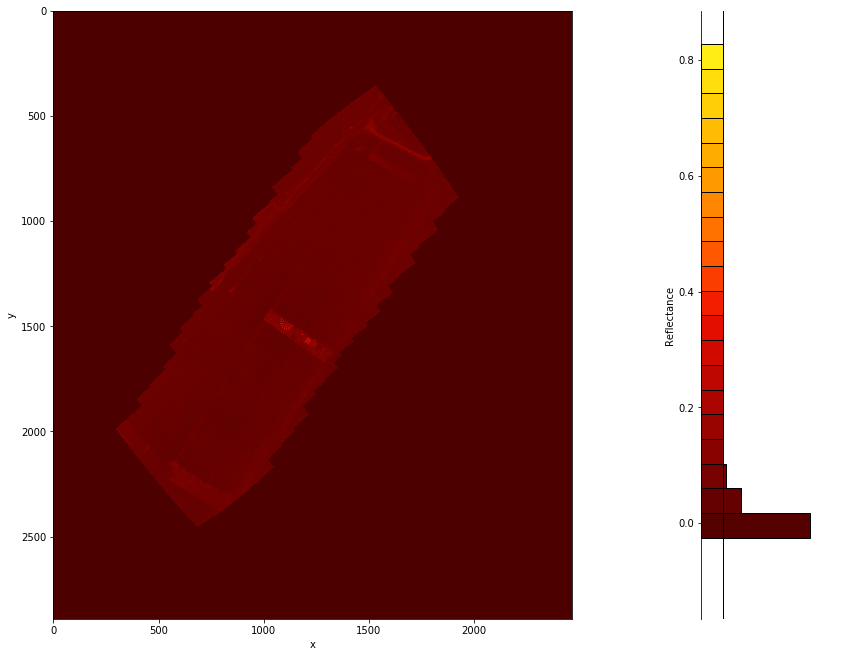
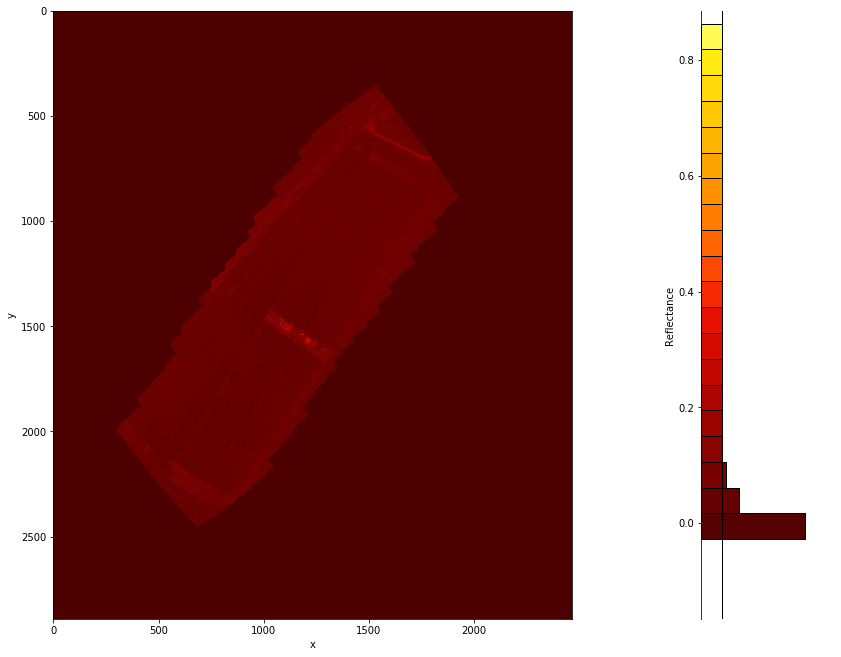
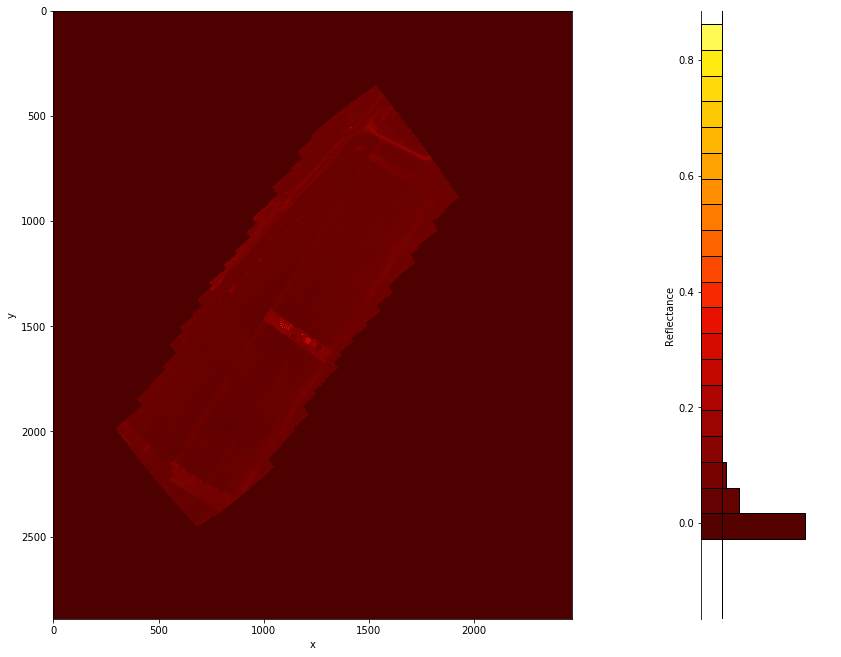
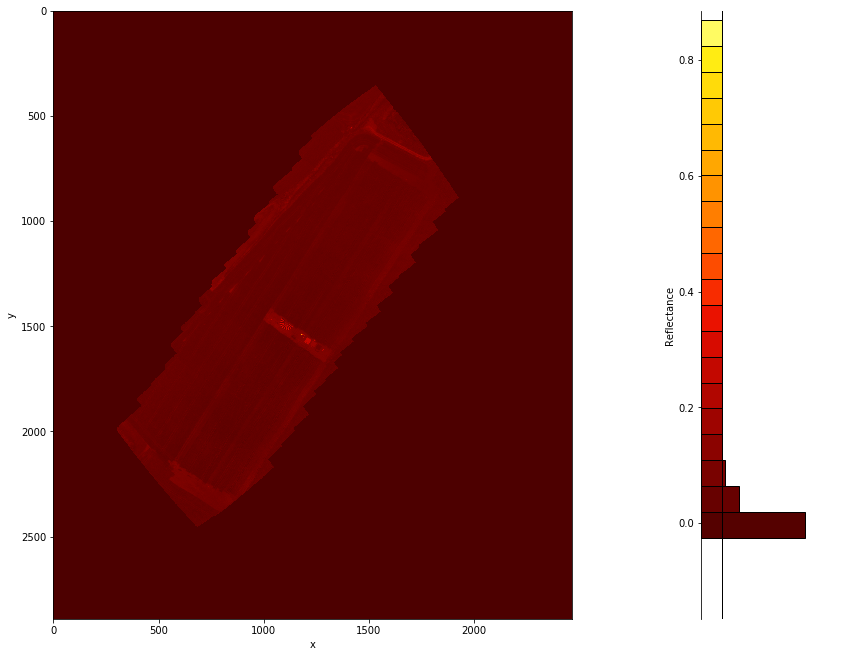
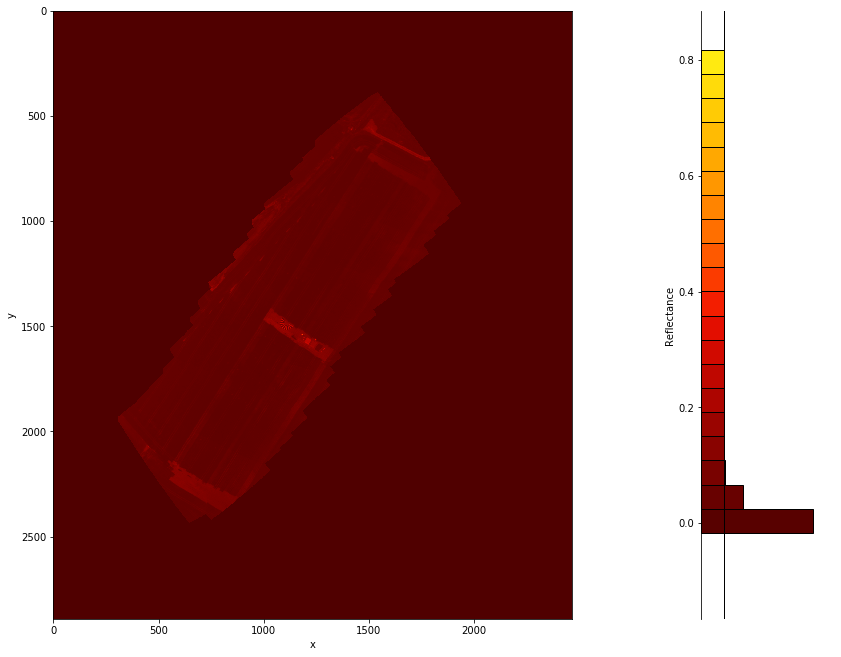
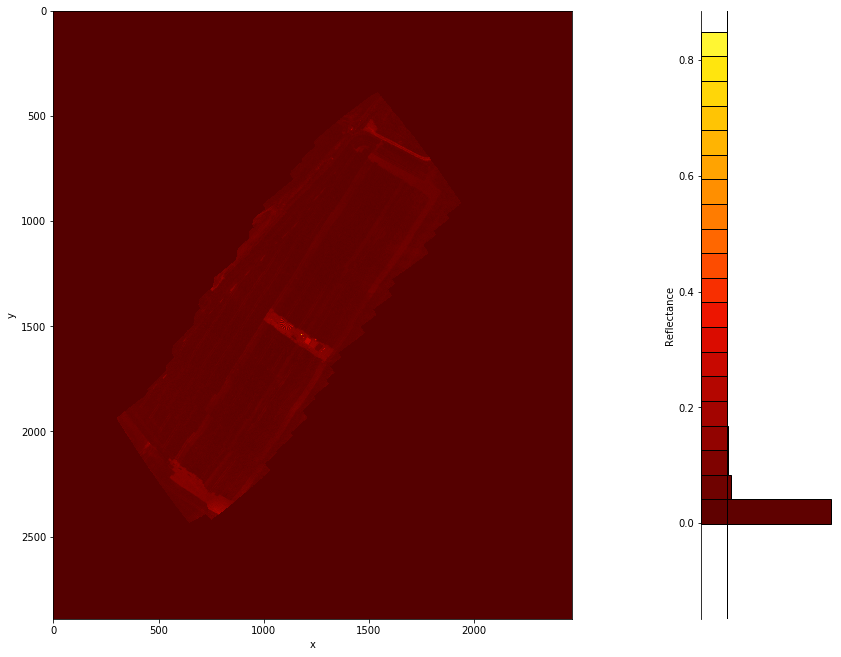
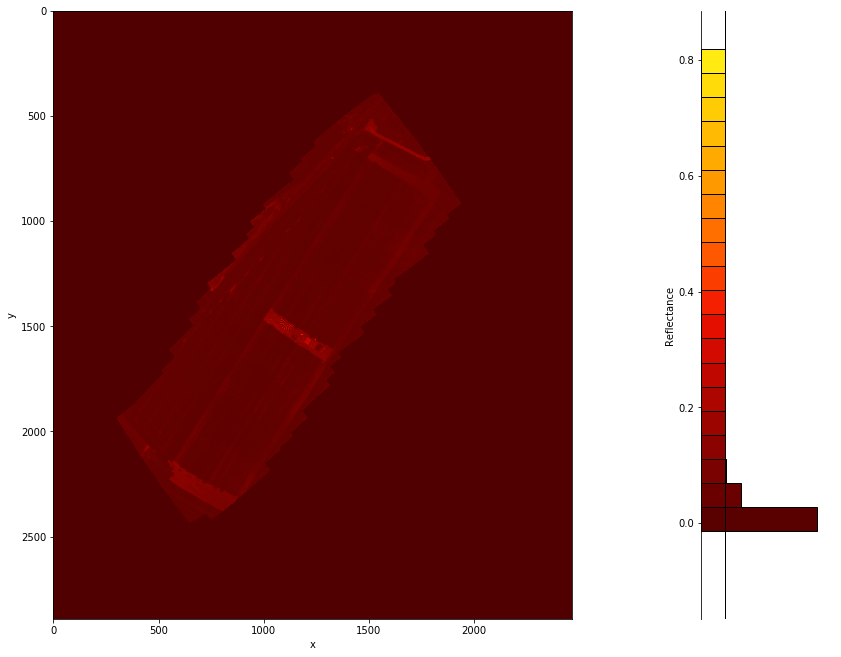
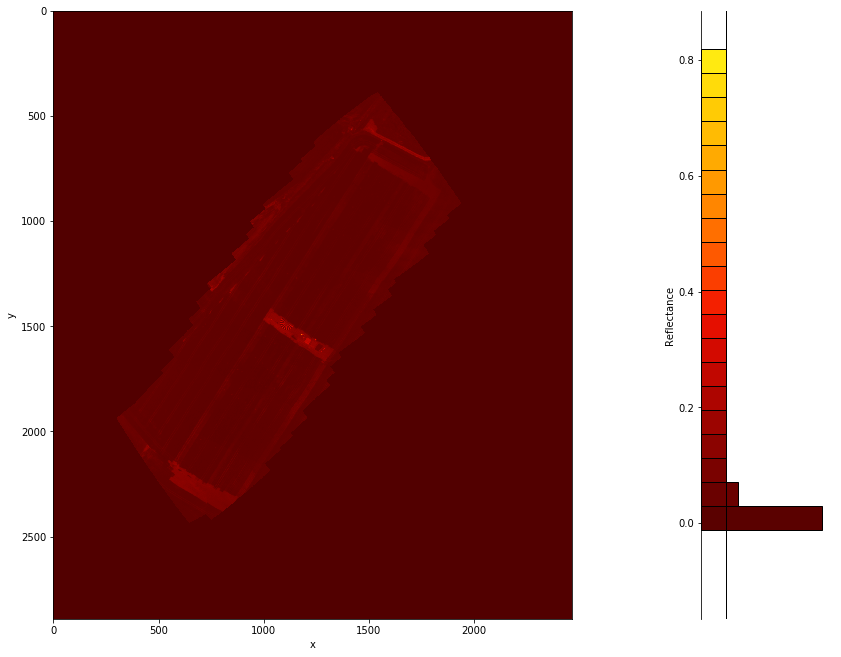
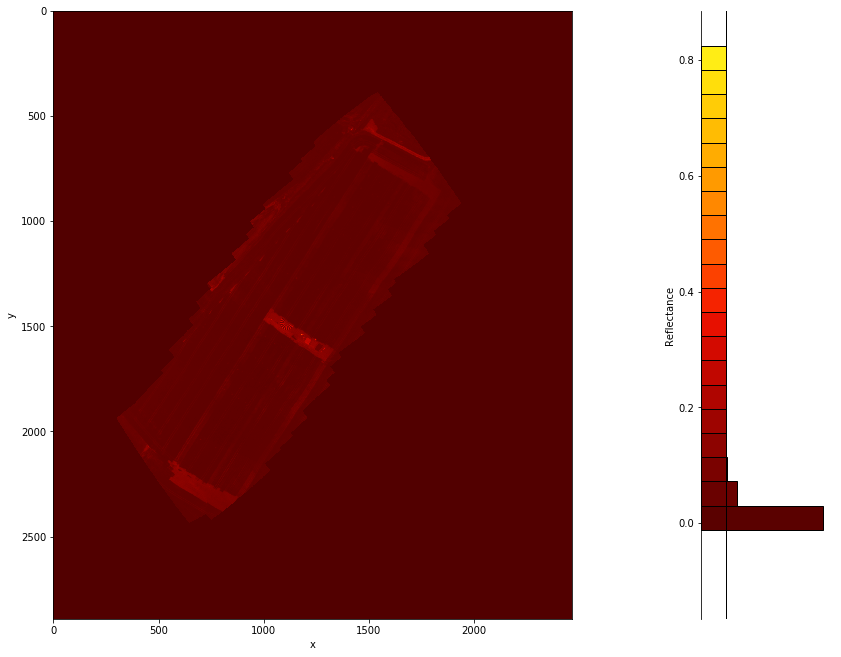
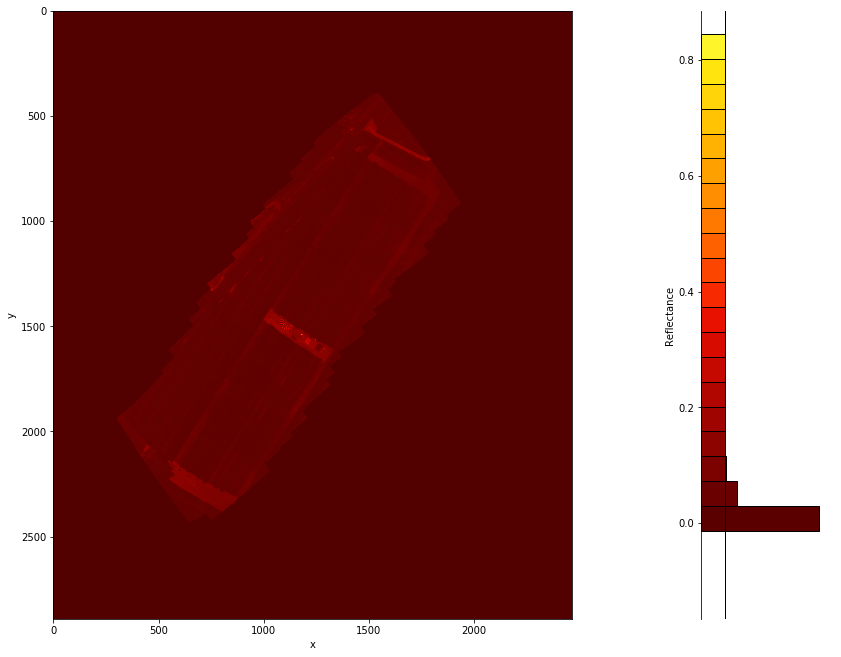
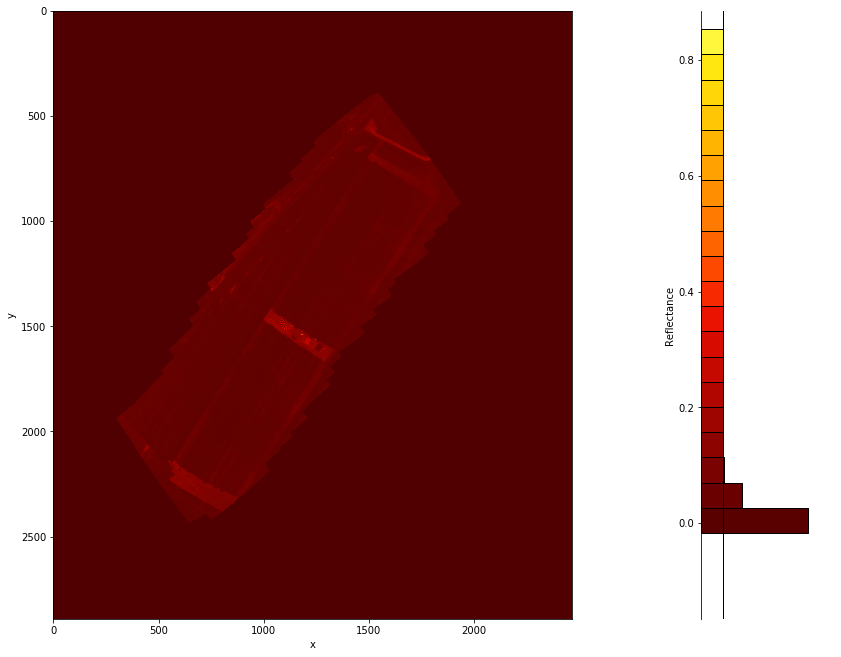
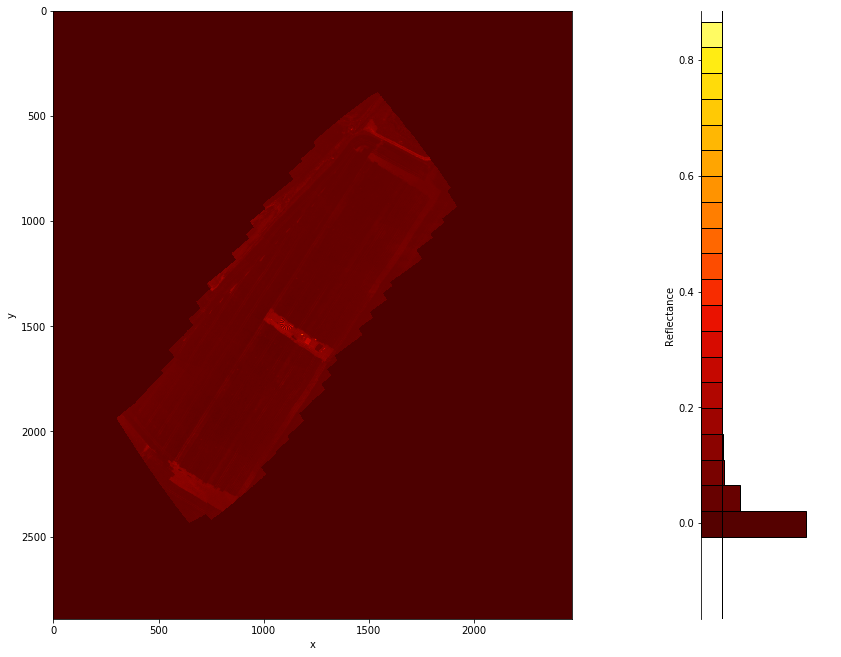
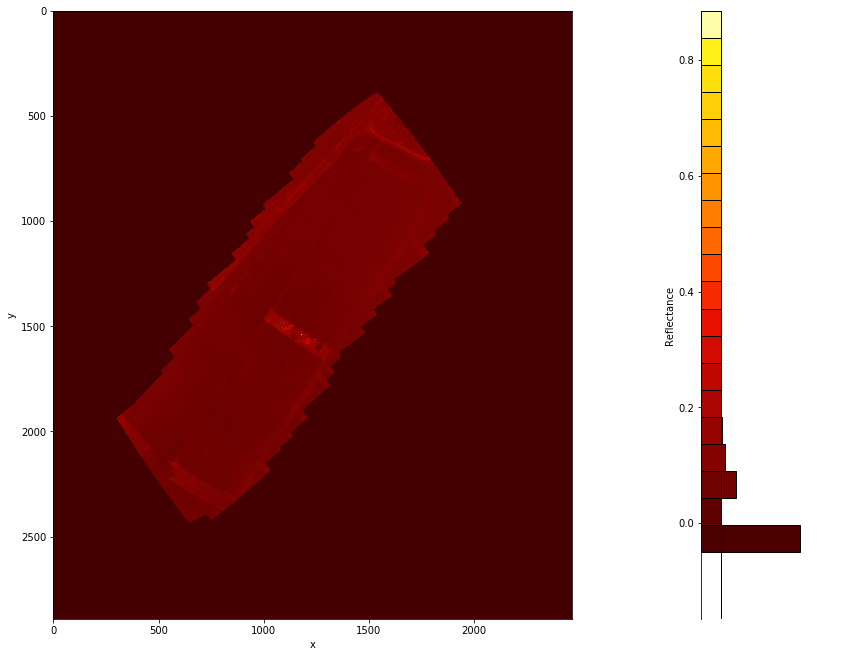
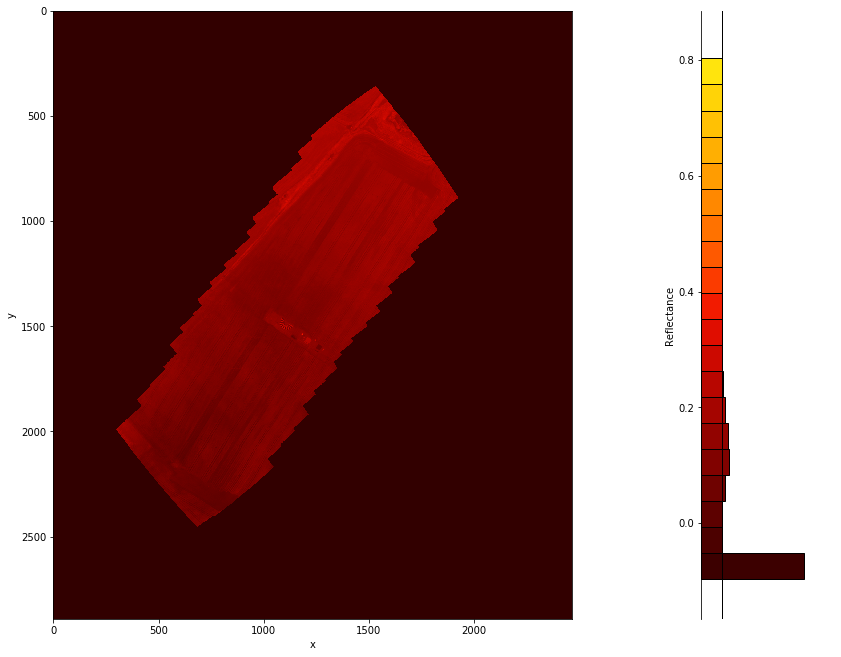
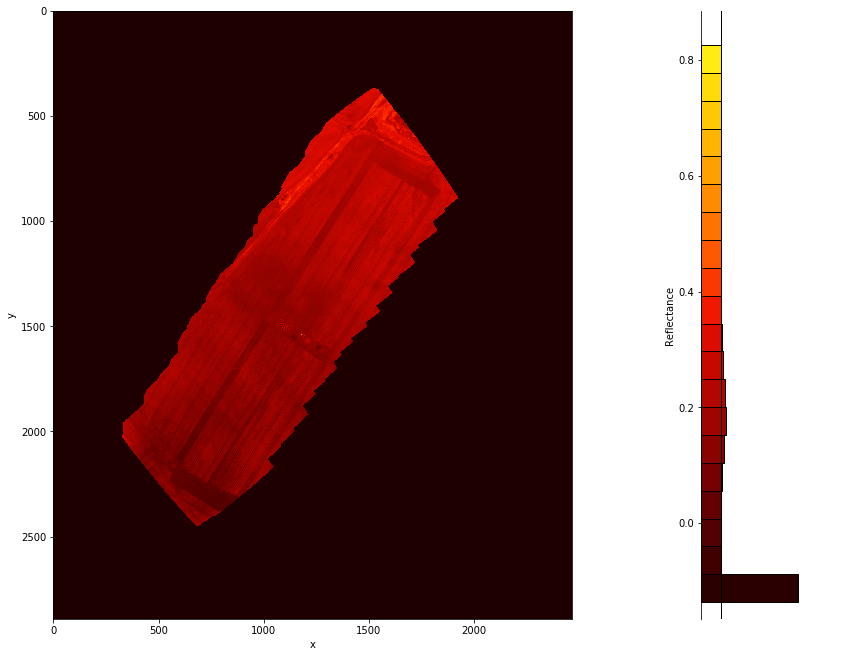
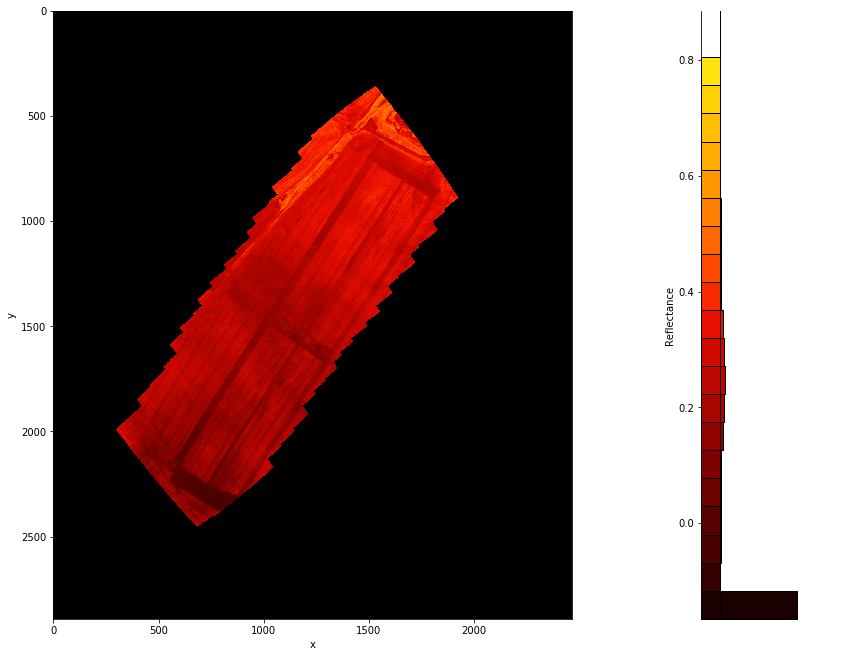
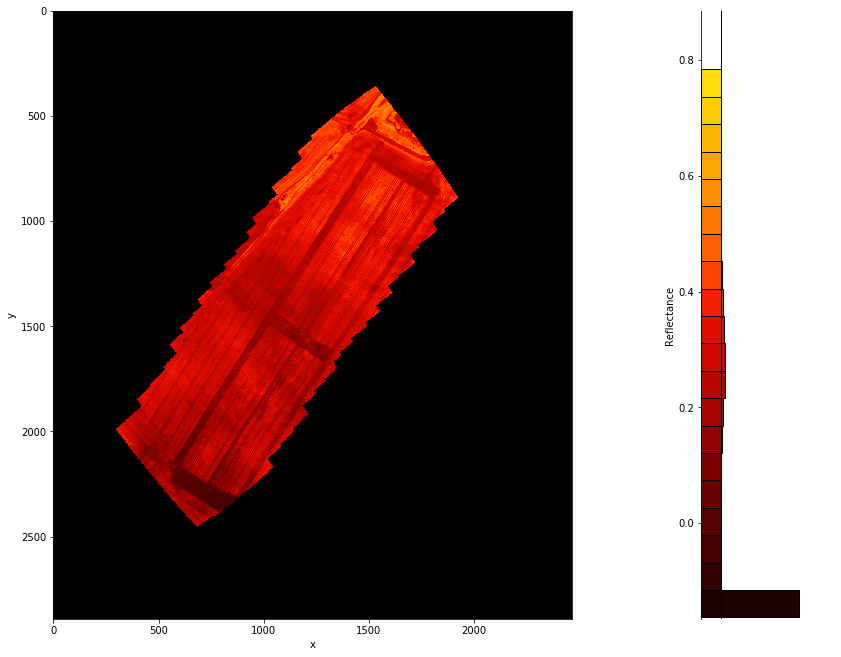
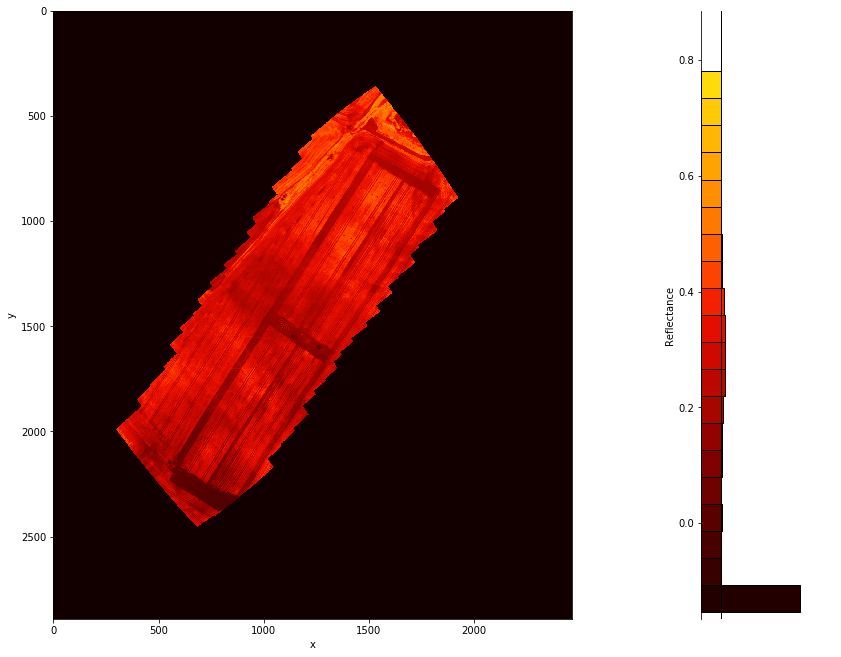
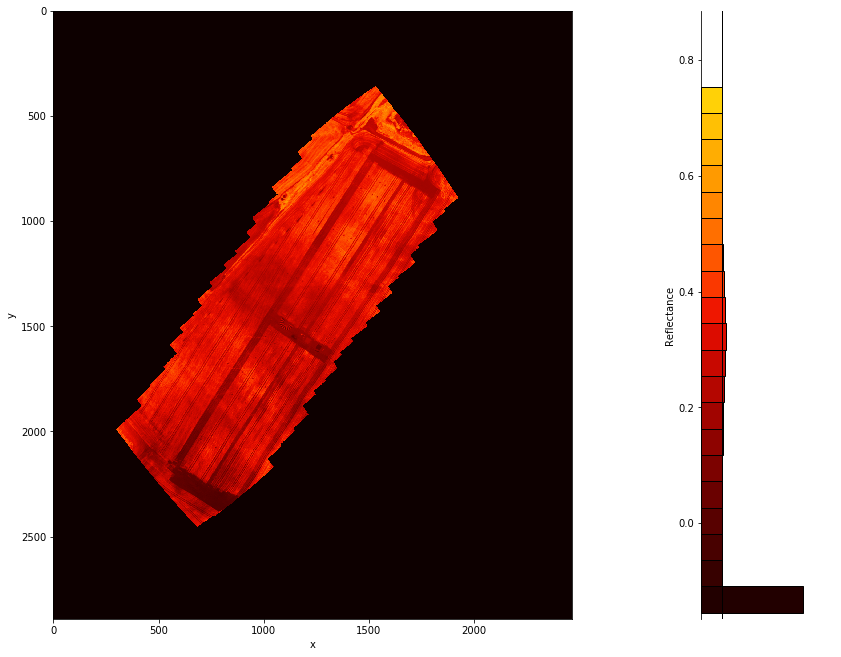
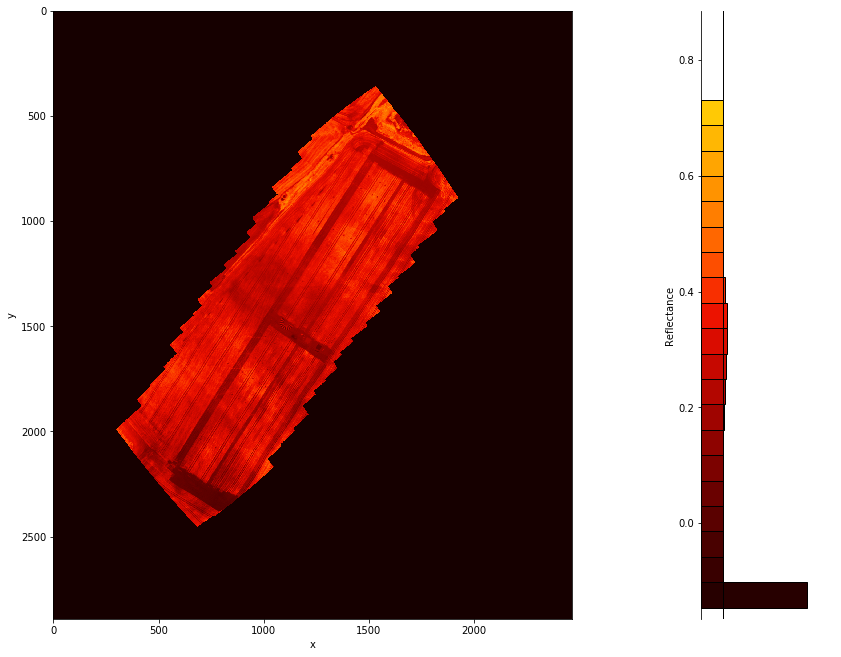
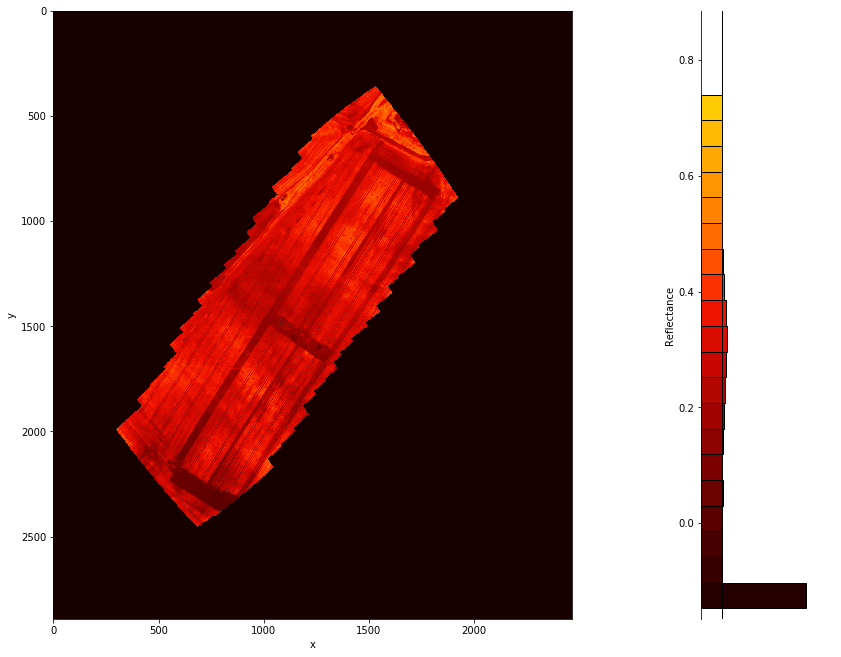
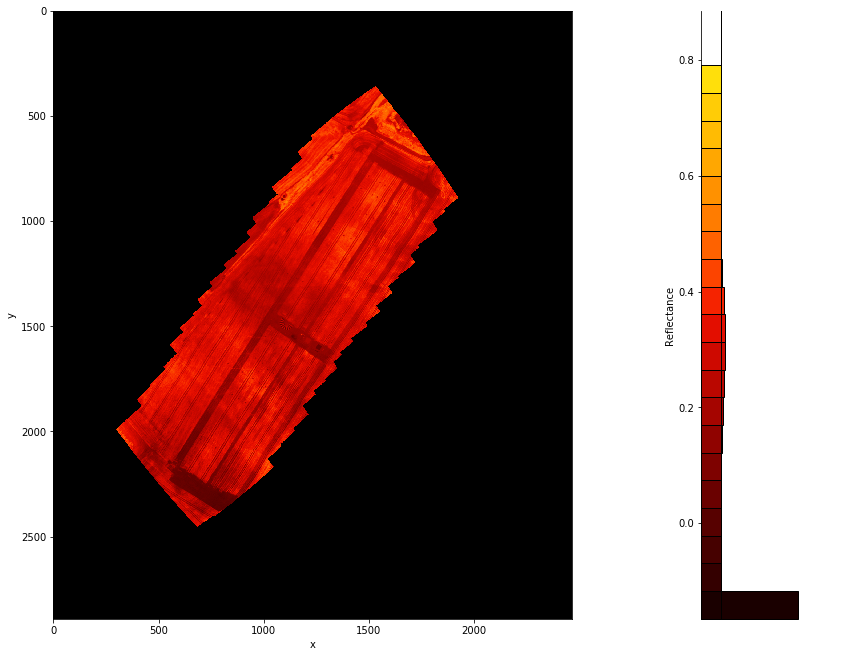

In [3]:
%%output size = 250
%%opts Image [invert_yaxis=True]
#holoviews assumes |_  axes, but image data comes with |‾ axes
dataset = hv.Dataset(field, kdims=['band', 'x', 'y'], vdims='Reflectance') #Constructing a holoviews dataset ...
dataset.to(hv.Image, ['x', 'y']).hist() #... to make building an interactive visualisation easy

I choose to set negative values and zeroes to numpy's NaN type to make processing easier.

In [4]:
field.values[field.values < 0] = np.nan

Now we can construct a pretty little holoviews object that allows you to see bands by their wavelength.

:AdjointLayout
   :HoloMap   [wavelength]
      :Image   [x,y]   (Reflectance)
   :HoloMap   [wavelength]
      :Histogram   [Reflectance]   (Reflectance_frequency)
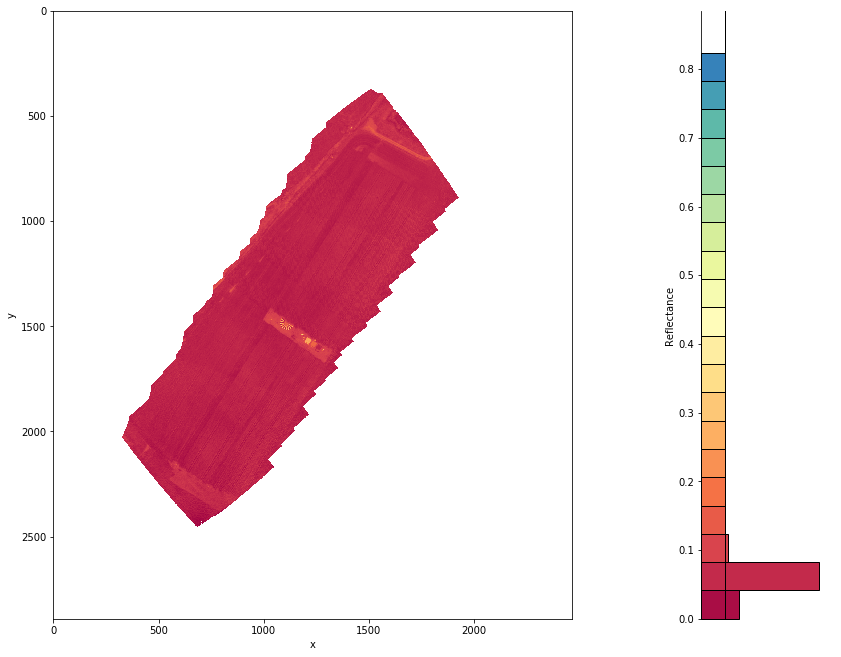
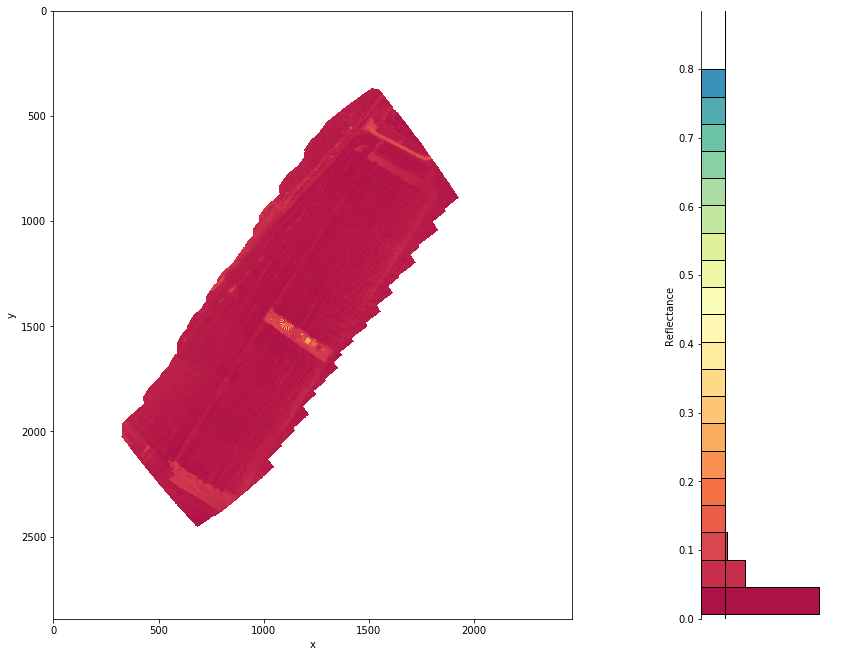
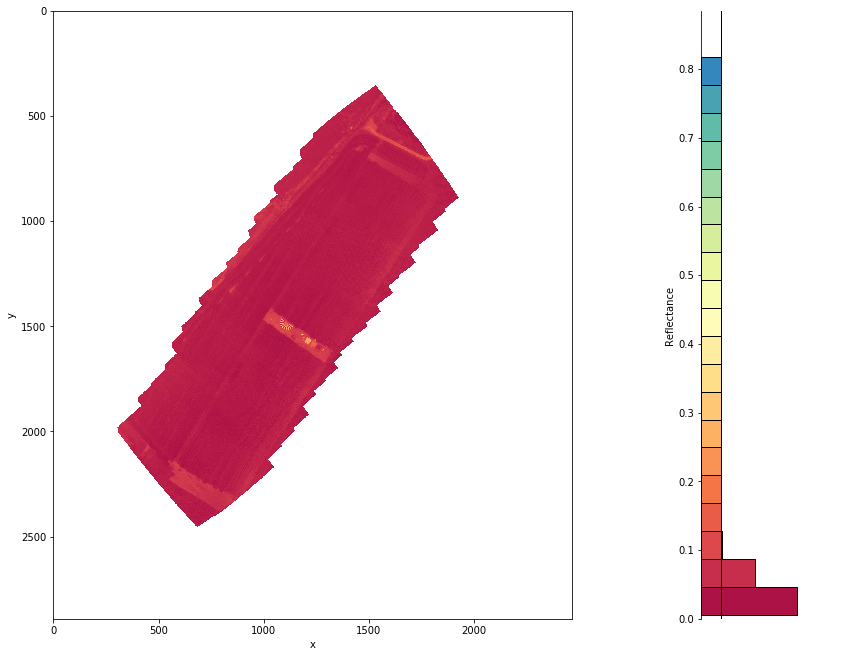
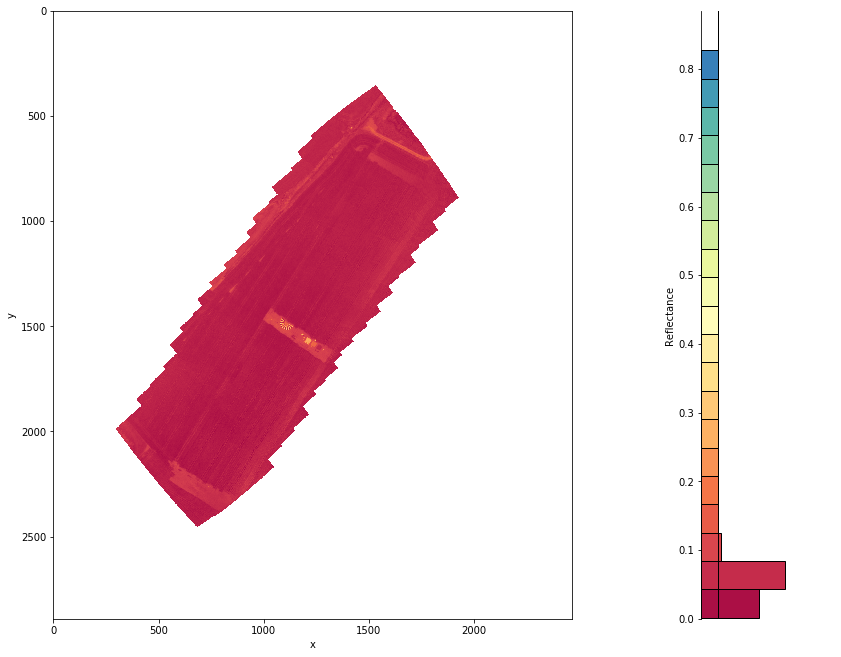
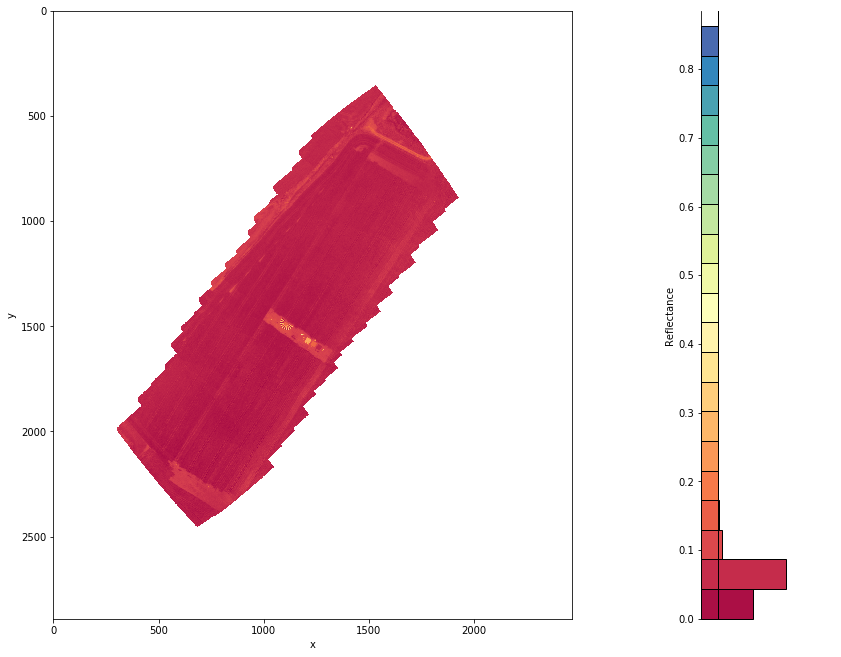
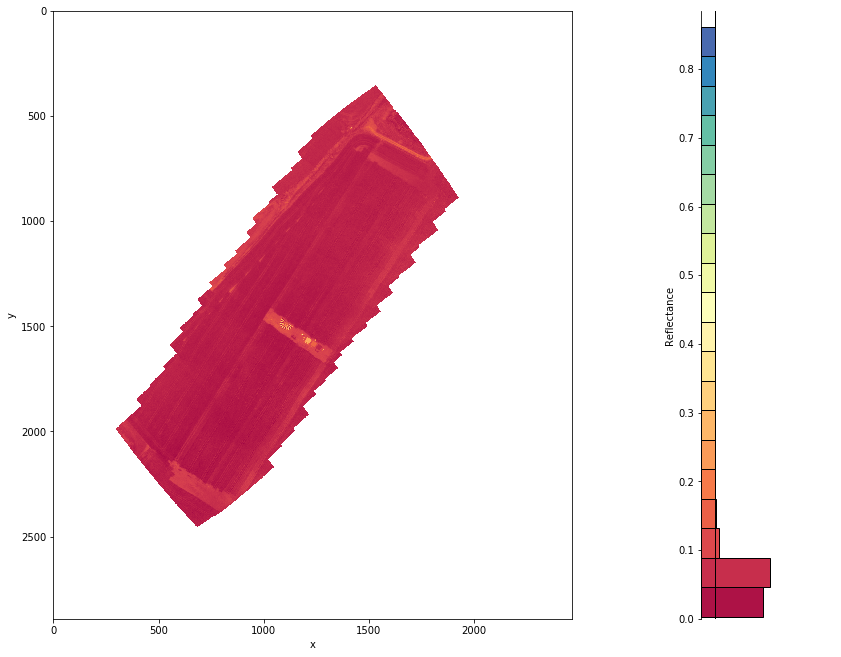
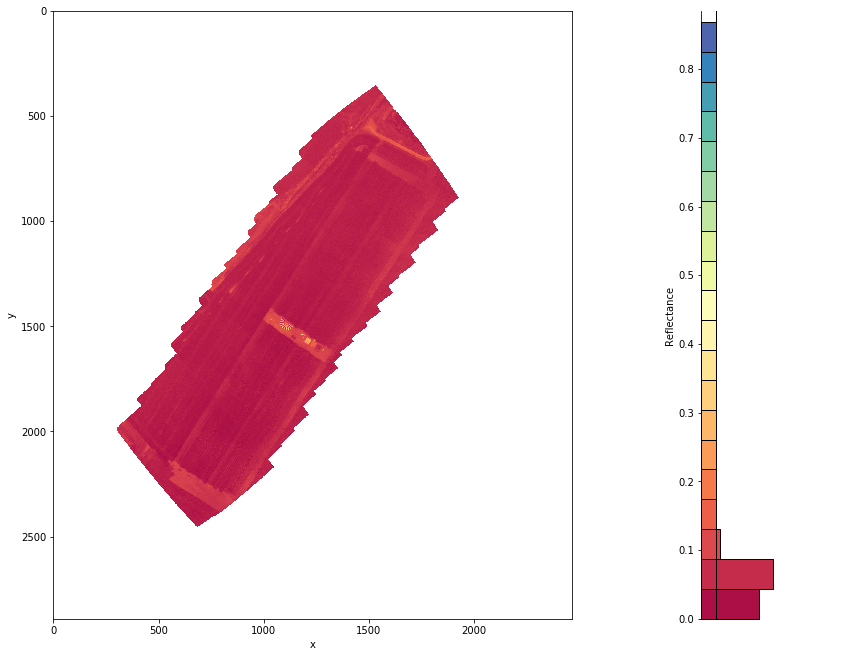
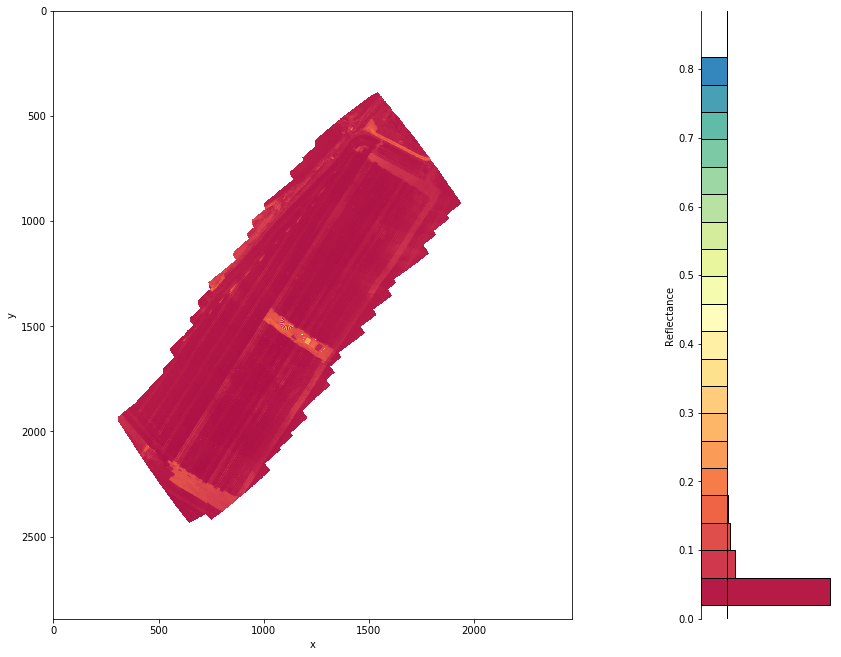
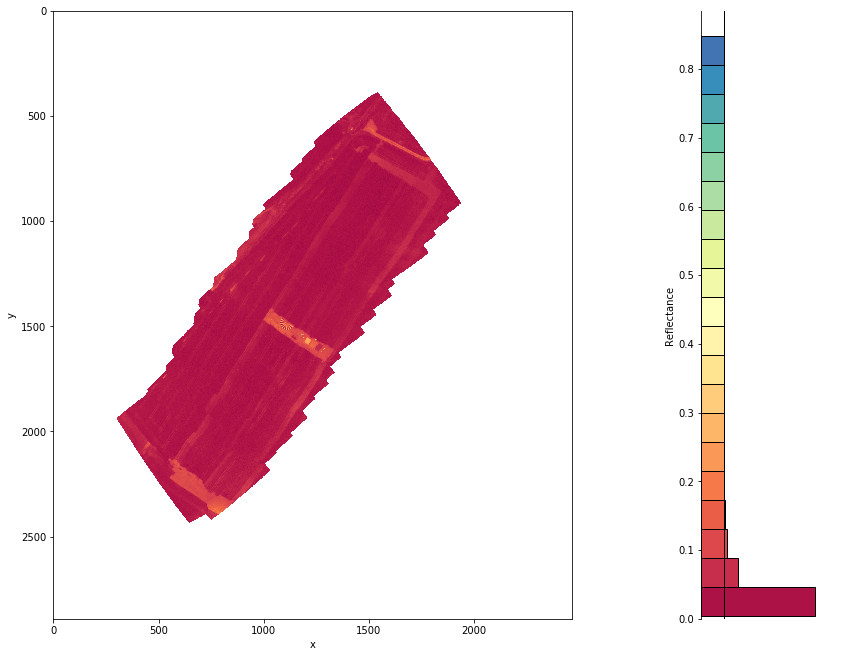
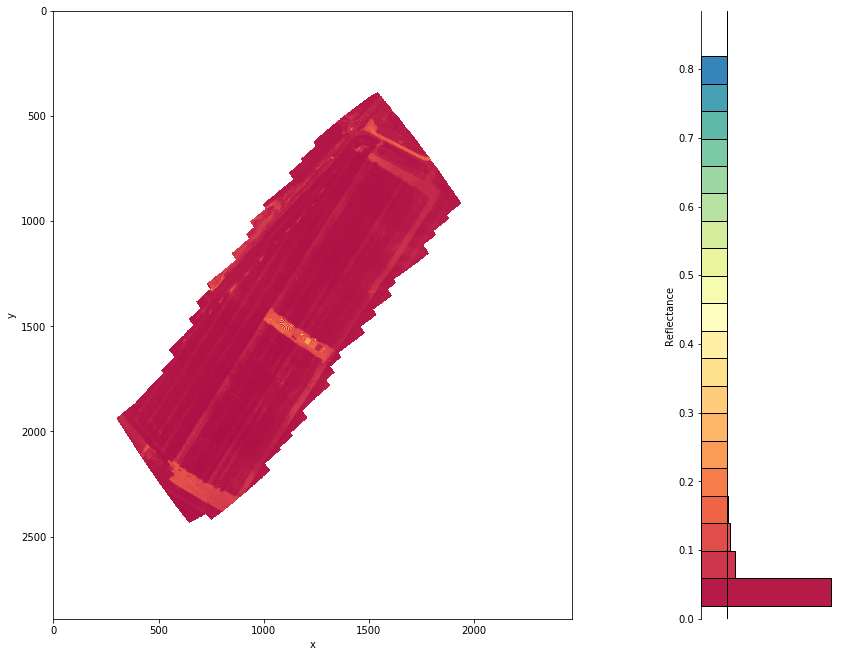
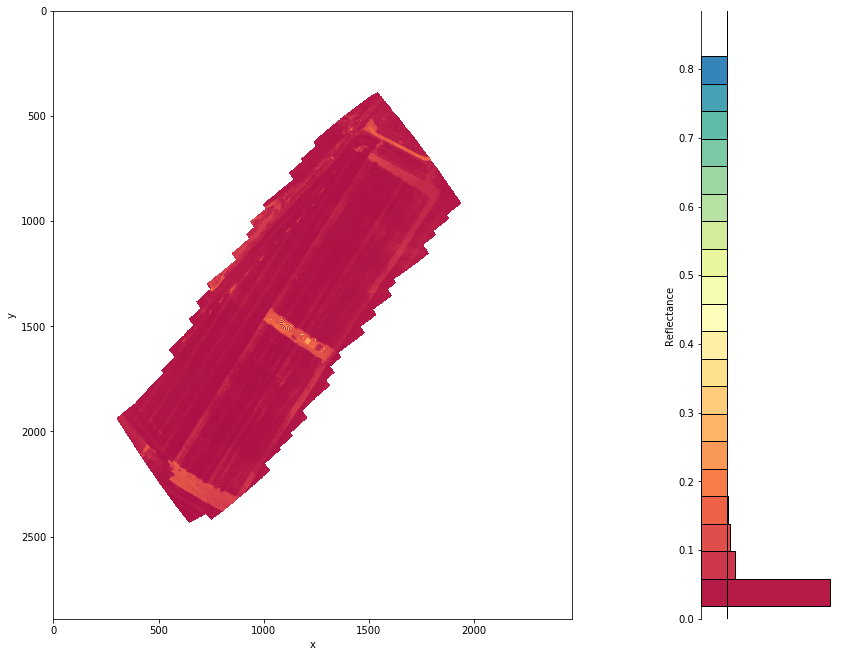
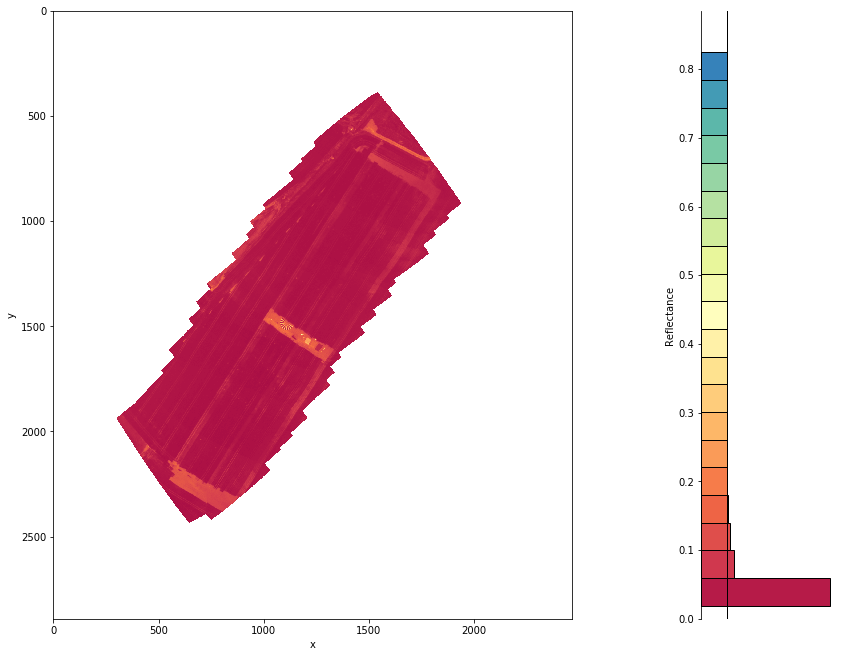
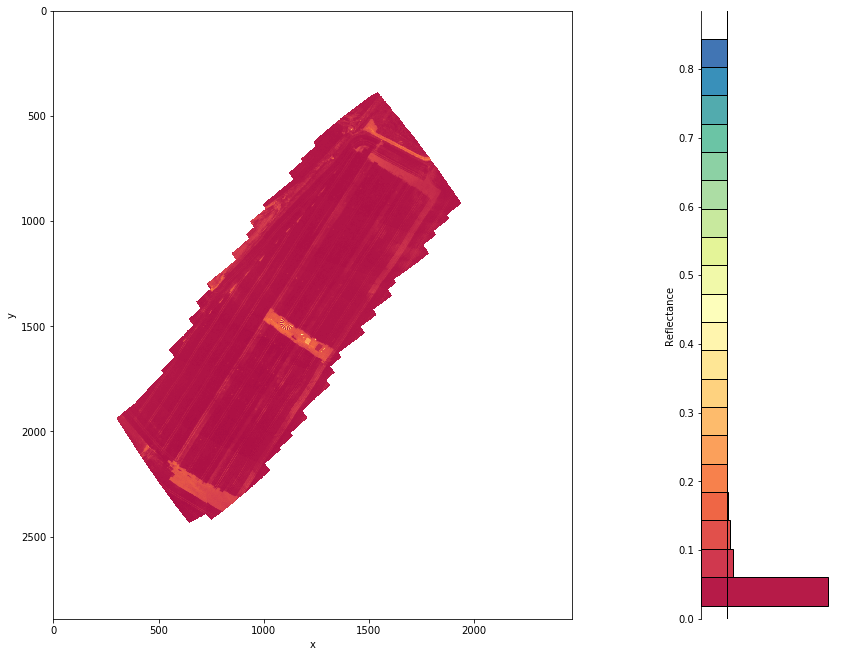
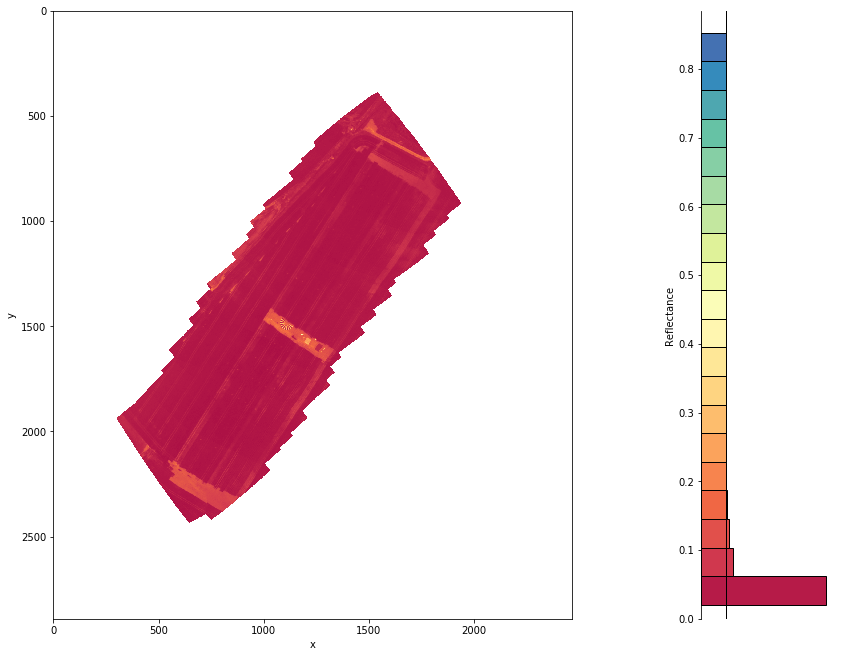
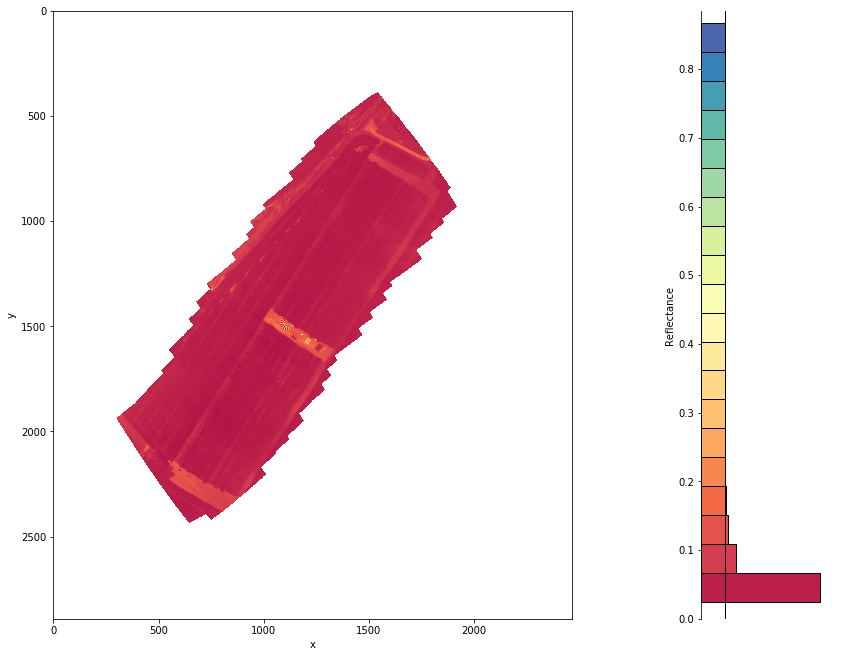
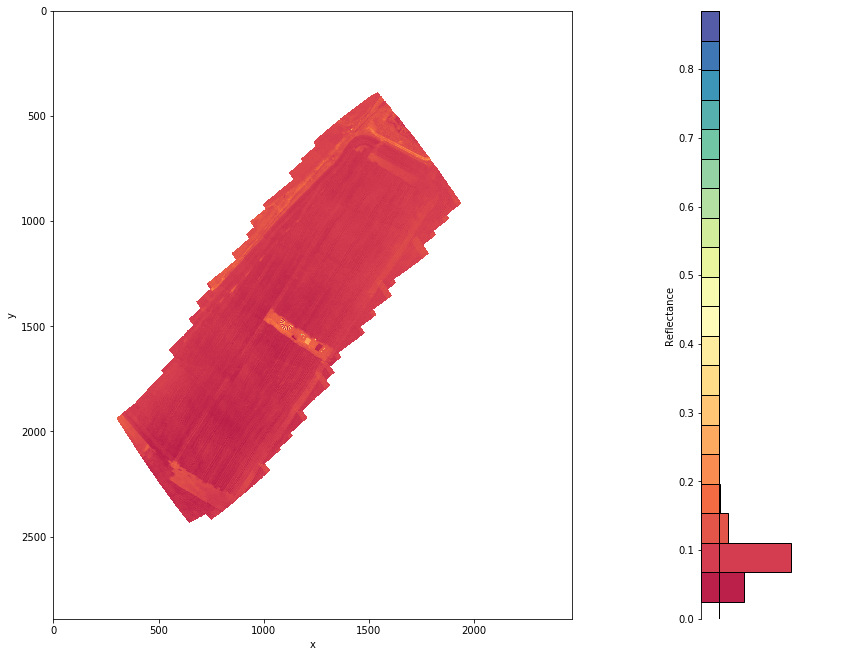
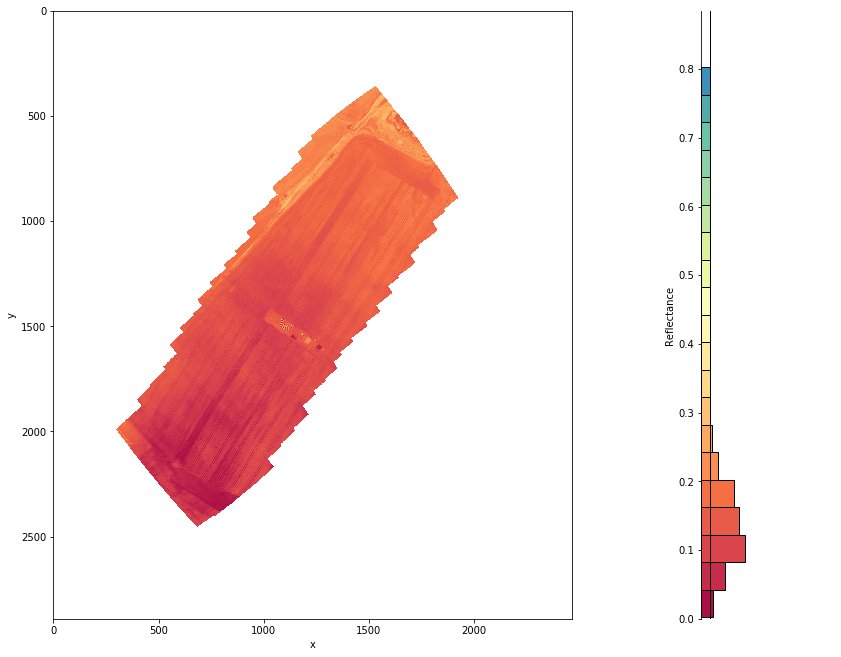
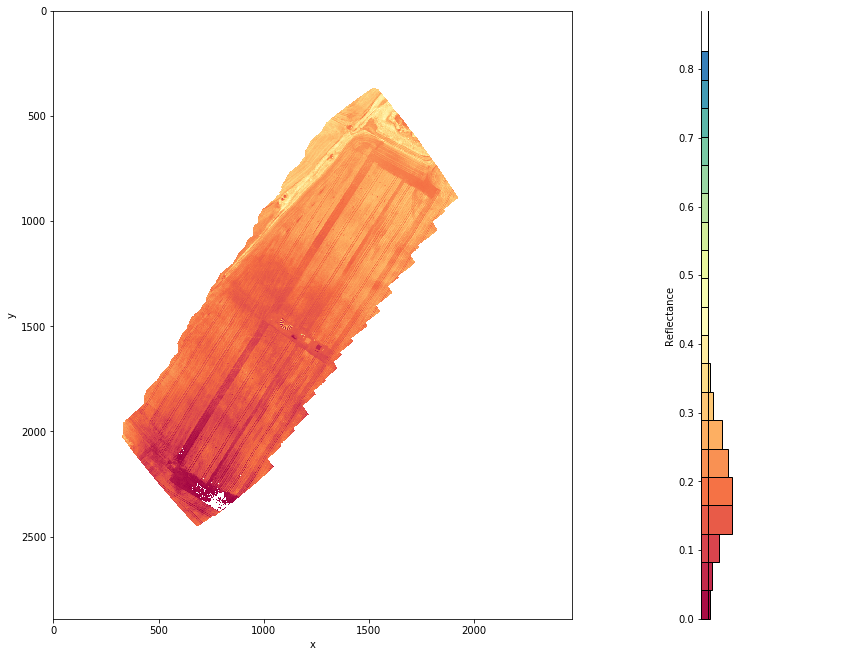
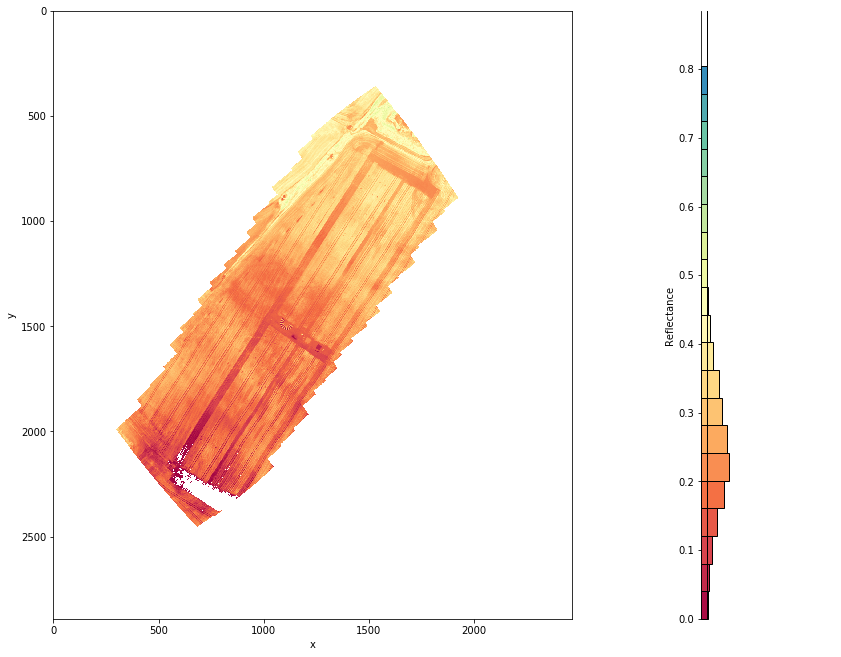
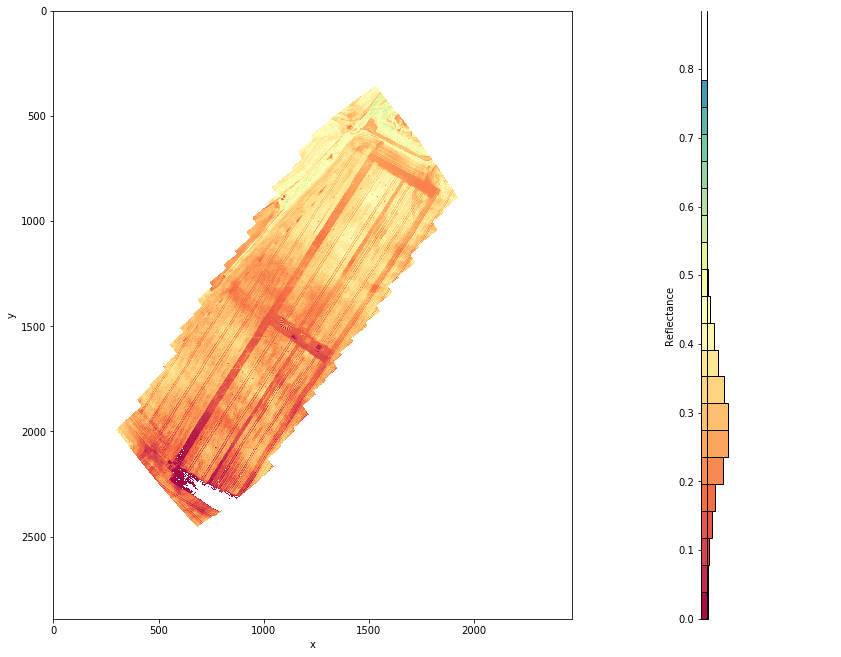
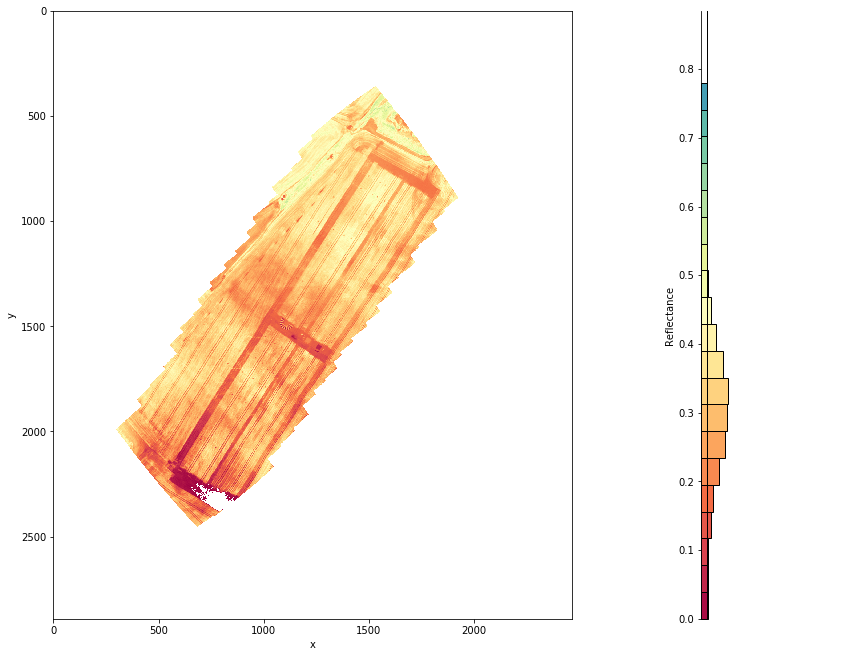
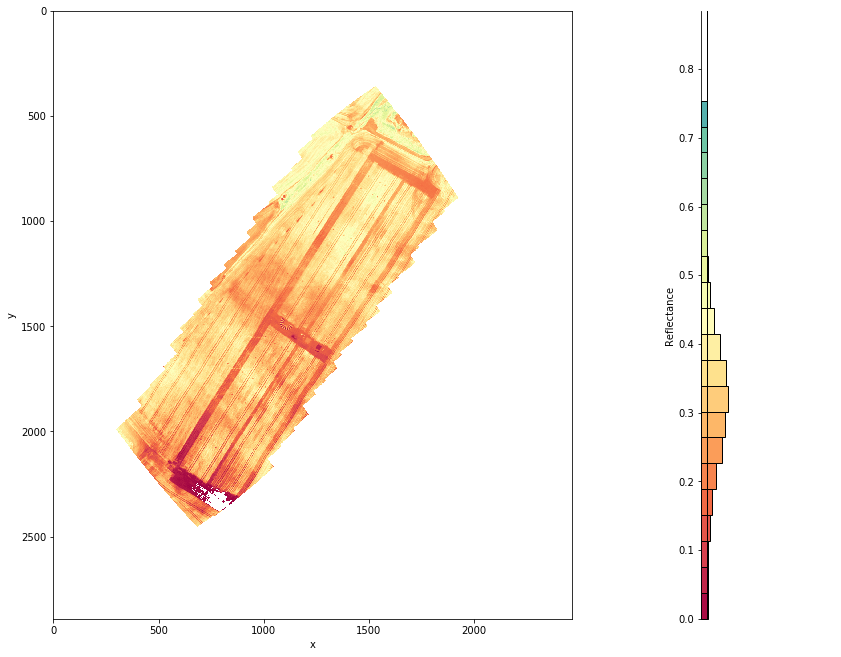
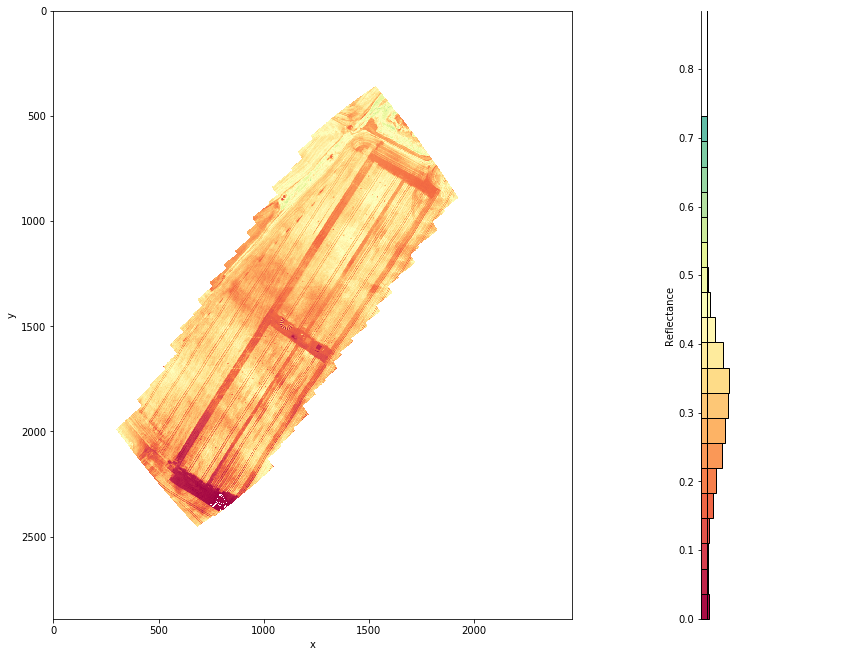
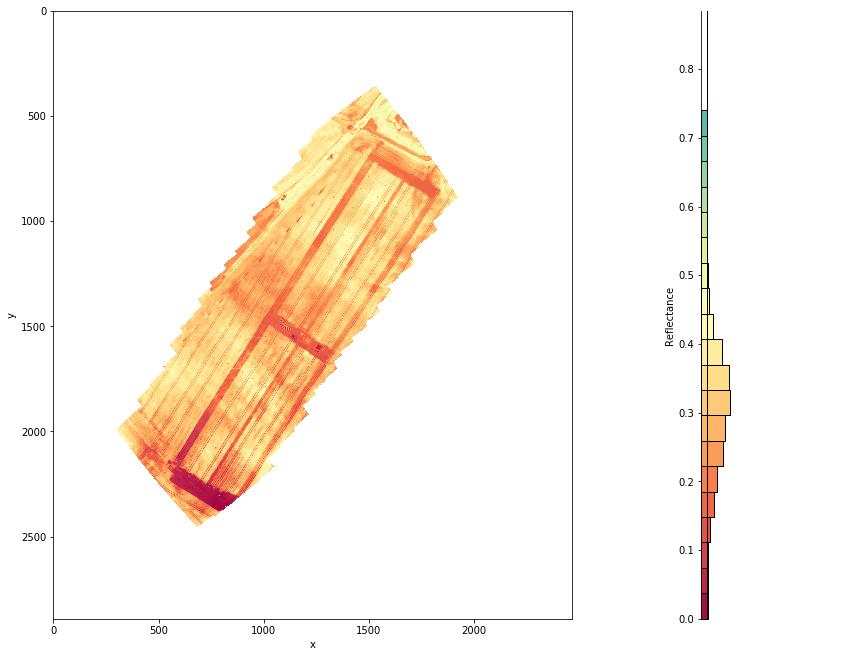
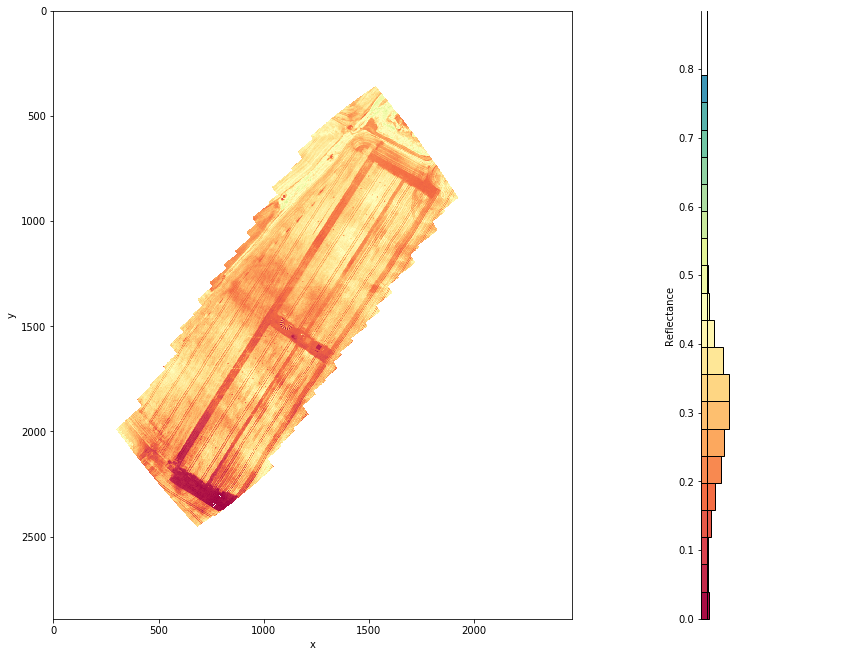

In [5]:
%%output size = 250
%%opts Image [invert_yaxis=True] (cmap='Spectral')
#I choose the Specral colourmap for readability's sake, but please PLEASE remember that colour is arbitrary.
#Colourmaps can easily be misleading.
dataset = hv.Dataset(field, kdims=['wavelength', 'x', 'y'], vdims='Reflectance')
dataset.to(hv.Image, ['x', 'y']).hist()

## Initializing and using pyspidl

Now that we have clean data, it is time to load the library for spectral indices. The library gives easy access to a number of spectral indices that have been retrieved from https://www.indexdatabase.de/. Some of the indexes have been defined using abstract parameters NIR, RED, etc. which in measurements have been measured trough a matching filter. I choose to supply the library with default values for these, although this may not be a very rigorous way to calculate them. The defaults are wavelengths from our instrument that roughly match the CIE Standard Observer, but I emphasise that this choise is essentially arbitrary.

In [6]:
defaults =  {'NIR': 815.7, 'GREEN': 544.2, 'RED': 595.3}
defaults.update({k: defaults['RED'] for k in ['Red', 'R']})
defaults['G'] = defaults['GREEN']
#Without defaults, we can not calculate some indices.
indices = ps.Indices(ps.selectors.from_xarray('wavelength', method='nearest', tolerance=8.0), defaults=defaults)

Note that I told the library to build the functions using xarray's .sel method and choosing wavelength by seeking nearest neighbour within 8 units, which is slightly more than the largest halfway point between wavelengths in our data.

We now have access to hyperspectral data and a supply of hyperspectral indices we can compute from it, so we can build a dataset using all available indices. The following snippet of code is slightly messy, so please read it with thought.

In [7]:
matches = dict()
for iname, ifunc in indices.items():
    try: #Try catch is a simple way to check for all indices that can actually be computed
        matches[iname] = ifunc(field)
        #The following is necessary to remove indices that result only in +inf, -inf and NaN
        if not np.any(np.isfinite(matches[iname])): 
            matches.pop(iname)
            continue
        #We have now built a dictionary of index names and corresponding data.    
        matches[iname].coords['index_name'] = iname
        #I also want to clean up unnecessary coordinates, if any remaim
        for coordinate in ['band', 'fwhm', 'wavelength']:
            if coordinate in matches[iname].coords:
                matches[iname] = matches[iname].drop(coordinate)
    except (KeyError, TypeError, NameError): #NameError should be removed when index library is complete
        pass
print(str(len(matches))+' matching indices found.')

170 matching indices found.


The last step is to convert the dictionary into a proper xarray.DataArray. This could probably be done on the fly, but I feel more comfortable doing it in steps.

In [8]:
field = xr.concat(matches.values(), 'index_name')
del matches

We can now examine each spectral index. Most of them are not expected to be useful for our vegetation data and some may not behave nicely due to having divisions by very small numbers. I ask the reader to take some time to play around with different indices.

Holoviews unfortunately has issues handling colourmap limits on an image by image basis if we use HoloMaps and DynamicMaps, so we deal with many indices having extreme outliers by flattening the data itself before plotting. If the issue is later resolved in Holoviews, this should be possible to do with less duct tape.

In [9]:
prettyfield = field.copy()
prc = 0.01 #Colourmaps will run from 1% to 99%
for index in prettyfield.index_name.values:
    prettyindex = prettyfield.sel(index_name=index)
    prettyindex.values[prettyindex.values <= prettyindex.quantile(prc).values] = prettyindex.quantile(prc).values
    prettyindex.values[prettyindex.values >= prettyindex.quantile(1-prc).values] = prettyindex.quantile(1-prc).values

In [10]:
dataset = hv.Dataset(prettyfield, kdims=['index_name', 'x', 'y'], vdims='Index')

:AdjointLayout
   :DynamicMap   [index_name]
   :DynamicMap   [index_name]
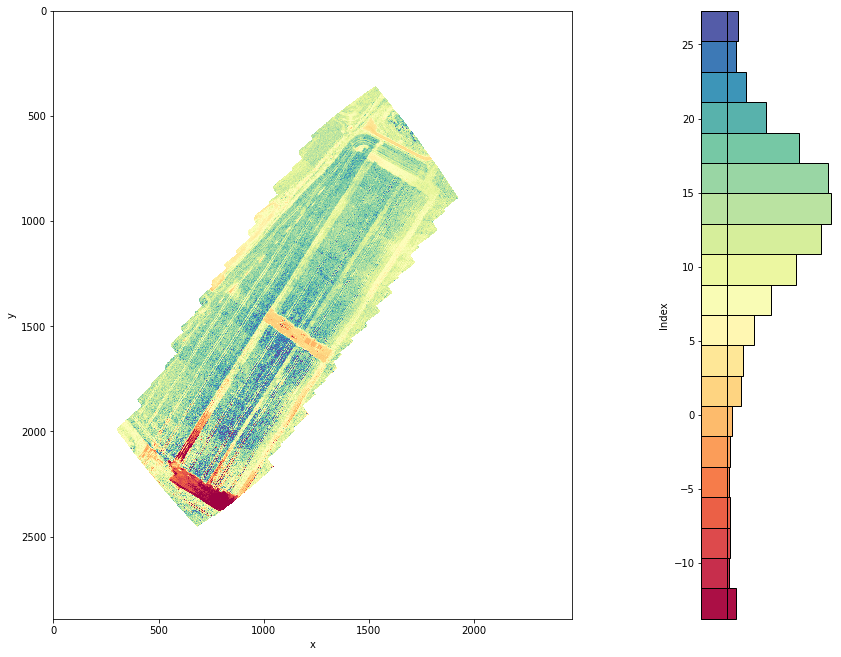

In [11]:
%%output size = 250
%%opts Image [invert_yaxis=True] (cmap='Spectral')
#Dynamic mode is unfortunately necessary to get around badly behaving indices.
#That is why this is not displayed on github or html presentations.
dataset.to(hv.Image, kdims=['x', 'y'], dynamic=True).hist()

First part of the analysis is now complete; we have pretty pictures.

## Loading reference data with Pandas

We can now try to investigate if any of the indexes have any meaning. For the field in Vihti there are measured quantities available in csv form, which is easy to load using Pandas. The header I had for the data is broken, so quantities are named by hand. I also translated them from Finnish to English on the fly, so some things may have been lost in translation.

In [12]:
tabulardata = pd.read_csv('/n/archive/IT/hsi-data/vihti2012/background_for_vihti2012.csv', header=None, names=['id',
                                                                                        'euref_long',
                                                                                        'euref_lat',
                                                                                        'px',
                                                                                        'py',
                                                                                        'num',
                                                                                        'x',
                                                                                        'y',
                                                                                        'z',
                                                                                        'fertilizerkgha',
                                                                                        'seedperc',
                                                                                        'dryweightkgha',
                                                                                        'humidperc',
                                                                                        'nitrogenperc',
                                                                                        'yieldpredict1',
                                                                                        'yieldpredict2',
                                                                                        'sample',
                                                                                        'grainwaterperc',
                                                                                        'yieldkgha',
                                                                                        'yieldnitrogenperc',
                                                                                        'extrafertilizer'])

In [13]:
quantities = ['fertilizerkgha',
              'seedperc',
              'dryweightkgha',
              'humidperc',
              'nitrogenperc',
              'yieldpredict1',
              'yieldpredict2',
              'grainwaterperc',
              'yieldkgha',
              'yieldnitrogenperc',
              'extrafertilizer'] 

## Brewing data into information

Before we get to visualising the data, it would be nice to have access to correlations between measured quantities and spectral indices. The correlation method of pandas and correlation coefficient function of numpy do not automatically provide p-values for the computed correlations, so we need to import stats from scipy to get access to stats.pearsonr. Since our spectral index data includes NaN in points of interest, this has to be taken into account as well.

In [14]:
def indextodata(indexdata, quantitydata):
    #We drop points that include NaN, in order to get meaningful correlations.
    finites = np.isfinite(indexdata)
    
    r, p = stats.pearsonr(indexdata.values[finites], quantitydata.values[finites])
    return r, p, ~finites #~ is numpy for inverting booleans in arrays

At this point we can promote our mere data to the lofty status of information, as we define a callable object that holoviews can use for interactive visualisation. I also cut the map data to the relevant area by slicing it, under the assumption this might reserve less memory than setting image bounds would. If I am wrong, simply passing bounds to a holoviews object would be cleaner code.

In [15]:
marg = 100
window = dict(x = slice(min(tabulardata.px) - marg, max(tabulardata.px) + marg),
              y = slice(min(tabulardata.py) - marg, max(tabulardata.py) + marg))

prettyfield = prettyfield[window]

In [16]:
def information (index, quantity, outside):
    #Selector for if we want to include zero reference points
    if outside == False:
        pointydata = tabulardata[:-10]
    else:
        pointydata = tabulardata
    #The points in the image that correspond to measurements
    pointyfield = field.isel_points(x=pointydata.px, y=pointydata.py)
    #Correlation coefficients    
    r, p, nans = indextodata(pointyfield.sel(index_name=index), pointydata[quantity])
    #Hyperspectral image for selected index
    image = hv.Image(prettyfield.sel(index_name=index), kdims=['x','y'])
    #Reference data
    points = hv.Points(pointydata, kdims=['px', 'py'], vdims=quantity).opts(style=dict(marker='x', s=100, linewidth=1))
    #The points for which correlation coefficients could not be defined
    failpoints = hv.Points((pointyfield.x[nans], pointyfield.y[nans])).opts(style=dict(marker='o', s=200, color='r'))
    #Plot of indexes vs reference and the corresponding correlations
    title = 'pearson_R: {}\n p-value: {}'.format(r, p)
    plottable = (pointydata[quantity], pointyfield.sel(index_name=index))
    plot = hv.Scatter(plottable).redim.label(x=quantity, y=index).opts(plot=dict(title_format=title, fontsize={'title':20}))
    #The clunky use of redim.label and opts is necessary to get around https://github.com/ioam/holoviews/issues/1918    
    return (image * points * failpoints + plot).cols(1)

With data processing in place, all we need to do is create an interactive visualisation with holoviews. We have had to set some options via .opts methods and some will be set via %%opts magic, which may be a bit confusing.

:DynamicMap   [index_name,quantity,outside]
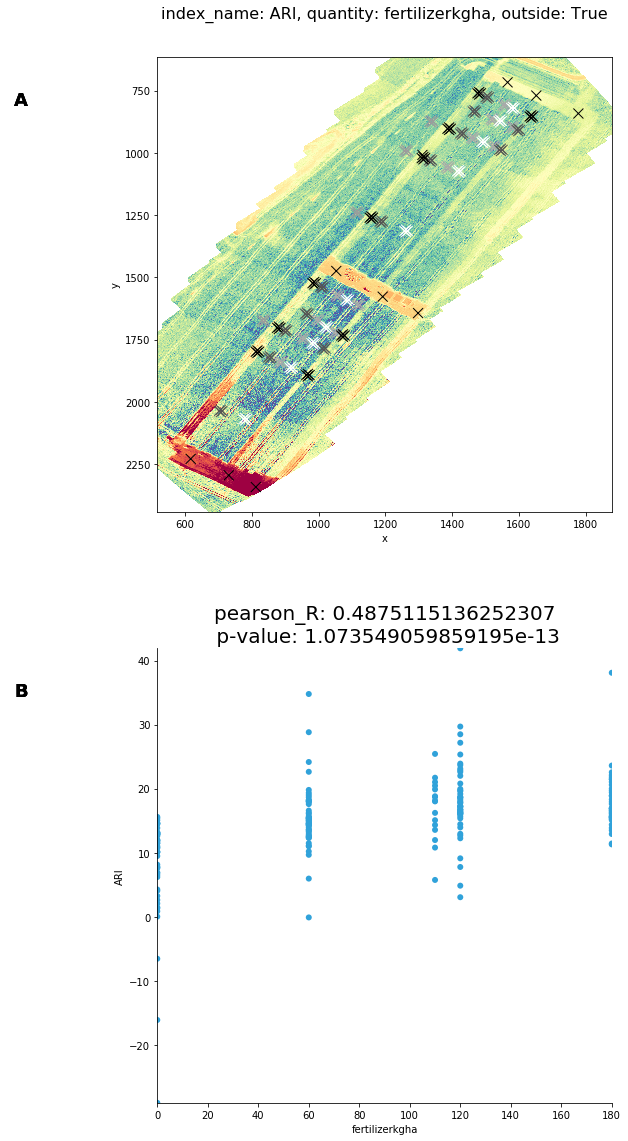

In [17]:
%%output size = 250
%%opts Image [invert_yaxis=True] (cmap='Spectral')
%%opts Points [color_index=2] (cmap='gray')

display = hv.DynamicMap(information, kdims=['index_name', 'quantity', 'outside'])
display.redim.values(index_name=field.index_name.values, quantity=quantities, outside=[True, False])

Some of the reference points refer to areas outside the field where all of the measured quantities are zero. A selector for them has been included, since it is interesting to study if including or omitting them results in misleading correlation values. A red dot indicates points for which correlation coefficient could not be calculated.

## Additional statistics

The above tool contains all the information we have, but it would be helpful to have some statistics on which indices correlate best with each quantity.

In [18]:
pointyfield = field.isel_points(x=tabulardata.px, y=tabulardata.py)

corr = []
ps = []
for index in field.index_name.values:
    clist = []
    plist = []
    for quantity in quantities:
        r, p, w = indextodata(pointyfield.sel(index_name=index), tabulardata[quantity])
        clist.append(r)
        plist.append(p)
    corr.append(clist)
    ps.append(plist)

Building DataArrays from these lists of lists is especially easy, since we already have data structures from which we can derive the coordinates.

In [19]:
xrcorr = xr.DataArray(corr, coords=[('index_name', field.index_name), ('quantity', quantities)])
xrps = xr.DataArray(ps, coords=[('index_name', field.index_name), ('quantity', quantities)])

Adding an additional coordinate derived from the data is useful for two reasons. First, I am interested in absolute values of the correlations and not really in the direction of the correlations, and second it allows us to use the .sortby() method of DataArrays with very clean notation.

In [20]:
xrcorr.coords['absolute'] = np.abs(xrcorr)

.sortby() orders items by ascending order by default, and puts NaN values last, so we need to reverse the order and remove the two indexes known to have non-finite correlations. This is why the slice is from second to 12th index, so we get the 10 best correlations for each measured quantity. Note that I chose to include the points where all measured quantities are zero, which may lead to misleadingly high correlations for some indices, as there can be a correlation in the sense of the index detecting the difference between there being no vegetation and there being some vegetation. You can explore this behiaviour with the above DynamicMap.

In [21]:
tabledict = {q: hv.Table(xrcorr.sel(quantity=q).sortby('absolute', ascending=False)[2:12],
                         kdims='index_name', vdims='pearson_R') for q in quantities}

:NdLayout   [quantity]
   :Table   [index_name]   (pearson_R)
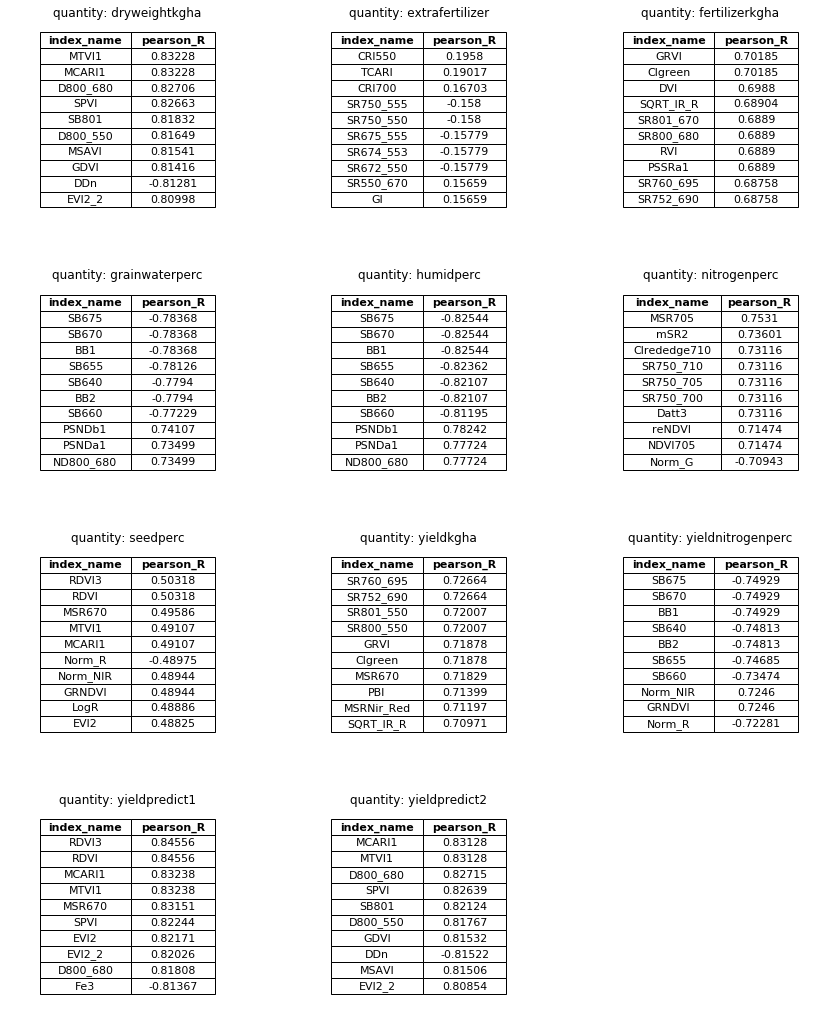

In [22]:
hv.NdLayout(tabledict, kdims='quantity').cols(3)

That looks nice. We have now played around with Jyputer Notebooks, Holoviews Datasets and their methods, Xarray's various ways of indexing data, the in-development library of spectral indexes, the basics of Pandas, Python's dictionaries, Xarray's built-in tools and interactivity provided by Holoviews. I learned quite a bit about what the Python ecosystem provides for data analysis while working on this notebook, and hopefully any readers will learn something as well.